In [163]:
import pandas as pd
import numpy as np
from scipy import stats
import os
import csv
import gzip
import shutil
import collections
import re
import io
import json
import xml.etree.ElementTree as ET
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics


In [164]:
data = pd.read_csv(r'https://raw.githubusercontent.com/dataconHack/hackathon/main/data.csv')
bact_desc = pd.read_csv('https://raw.githubusercontent.com/dataconHack/hackathon/main/bacterial_descriptors.csv')
drug_desc = pd.read_csv('https://raw.githubusercontent.com/dataconHack/hackathon/main/drug_descriptors.csv')

# Предобработка данных

In [165]:
data[:10]

,Unnamed: 0.1,Unnamed: 0,Bacteria,NP_Synthesis,Drug,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check
0,0,86,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,NaN,NaN,4.0,10.0,8.0,spherical,MIC,32+,6.3,32+,NaN,1
1,1,87,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Penicillin,Carboxylic acids and derivatives,NaN,NaN,4.0,10.0,8.0,spherical,MIC,32+,6.3,32+,NaN,1
2,2,679,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,NaN,NaN,15.0,30.0,28.0,spherical,MIC,32+,25,32+,NaN,1
3,3,680,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Penicillin,Carboxylic acids and derivatives,NaN,NaN,15.0,30.0,28.0,spherical,MIC,32+,25,32+,NaN,1
4,4,638,Micrococcus luteus,green_synthesis from fungus Aspergillus flavus,Vancomycin,Carboxylic acids and derivatives,30.0,100,5.0,30.0,21.0,spherical,disc_diffusion,0,14,17+2,7.02,1
5,5,639,Micrococcus luteus,green_synthesis from fungus Aspergillus flavus,Gentamicin,Aminoglycosides,10.0,100,5.0,30.0,21.0,spherical,disc_diffusion,0,14,17+2,7.02,1
6,6,300,Staphylococcus aureus,green_synthesis using Dioscorea bulbifera tube...,Ceftazidime,Lactams,500.0,30,8.0,20.0,13.5,nanorods and triangles,disc_diffusion,12,NaN,15,0.60,0
7,7,764,Staphylococcus epidermidis,chem_synthesis by silver nitrate,Gentamicin,Aminoglycosides,NaN,NaN,20.0,40.0,30.0,spherical,MIC,500,NaN,62.5,NaN,1
8,8,432,Neisseria mucosa,green_synthesis using Dioscorea bulbifera tube...,Ampicillin,Lactams,500.0,30,8.0,20.0,13.5,nanorods and triangles,disc_diffusion,22,NaN,50,4.20,0
9,9,488,Neisseria mucosa,green_synthesis using Dioscorea bulbifera tube...,Penicillin,Carboxylic acids and derivatives,500.0,30,8.0,20.0,13.5,nanorods and triangles,disc_diffusion,46,NaN,48,0.10,0


In [166]:
# количество NaN в каждом свойстве
data.isna().sum(axis=0)

Unnamed: 0.1                                     0
Unnamed: 0                                       0
Bacteria                                         0
NP_Synthesis                                     0
Drug                                           241
Drug_class_drug_bank                           241
Drug_dose                                      306
NP_concentration                               250
NP size_min                                      0
NP size_max                                      0
NP size_avg                                      0
shape                                            0
method                                           0
ZOI_drug                                       256
ZOI_NP                                         442
ZOI_drug_NP                                    299
fold_increase_in_antibacterial_activity (%)    462
MDR_check                                        0
dtype: int64

In [167]:
len(data)

883

In [168]:
len(bact_desc)

59

In [169]:
len(drug_desc)

44

In [170]:
bact_desc[:10]

,Tax_id,Bacteria,kingdom,subkingdom,clade,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from
0,['470'],Acinetobacter baumannii,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Moraxellales,Moraxellaceae,Acinetobacter,Acinetobacter calcoaceticus/baumannii complex,n,24.00,36.00,48.0,37,2,urine
1,['715'],Actinobacillus pleuropneumoniae,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Actinobacillus,Actinobacillus pleuropneumoniae,n,24.00,36.00,48.0,37,2,lungs
2,['5599'],Alternaria alternata,Fungi,Dikarya,Opisthokonta,Ascomycota,Dothideomycetes,Pleosporales,Pleosporaceae,Alternaria,Alternaria alternata,NaN,48.00,192.00,336.0,30,2,food
3,['5059'],Aspergillus flavus,Fungi,Dikarya,Opisthokonta,Ascomycota,Eurotiomycetes,Eurotiales,Aspergillaceae,Aspergillus,Aspergillus flavus,NaN,24.00,36.00,48.0,37,2,soil
4,['162425'],Aspergillus nidulans,Fungi,Dikarya,Opisthokonta,Ascomycota,Eurotiomycetes,Eurotiales,Aspergillaceae,Aspergillus,Aspergillus nidulans,NaN,24.00,36.00,48.0,30,1,soil
5,['5061'],Aspergillus niger,Fungi,Dikarya,Opisthokonta,Ascomycota,Eurotiomycetes,Eurotiales,Aspergillaceae,Aspergillus,Aspergillus niger,NaN,24.00,36.00,48.0,30,1,soil
6,['1396'],Bacillus cereus,Bacteria,NaN,Terrabacteria group,Bacillota,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus cereus group,p,4.00,10.00,16.0,30,2,food
7,['1402'],Bacillus licheniformis,Bacteria,NaN,Terrabacteria group,Bacillota,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus subtilis group,p,16.00,20.00,24.0,37,1,soil
8,['1386'],Bacillus sp.,Bacteria,NaN,Terrabacteria group,Bacillota,Bacilli,Bacillales,Bacillaceae,Bacillus,unclassified Bacillus,p,4.00,10.00,16.0,30,2,soil
9,['1423'],Bacillus subtilis,Bacteria,NaN,Terrabacteria group,Bacillota,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus subtilis group,p,0.16,7.08,14.0,30,1,soil


In [171]:
# количество NaN в каждом свойстве
bact_desc.isna().sum(axis=0)

Tax_id                  0
Bacteria                0
kingdom                 0
subkingdom             47
clade                  26
phylum                  0
class                   0
order                   0
family                  0
genus                   0
species                 0
gram                   12
min_Incub_period, h     1
avg_Incub_period, h     0
max_Incub_period, h     1
growth_temp, C          0
biosafety_level         0
isolated_from           0
dtype: int64

In [172]:
drug_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     44 non-null     int64 
 1   drug           44 non-null     object
 2   chemID         44 non-null     object
 3   prefered_name  44 non-null     object
 4   smiles         44 non-null     object
dtypes: int64(1), object(4)
memory usage: 1.8+ KB


In [173]:
# количество NaN в каждом свойстве
drug_desc.isna().sum(axis=0)

Unnamed: 0       0
drug             0
chemID           0
prefered_name    0
smiles           0
dtype: int64

In [174]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Unnamed: 0.1                                 883 non-null    int64  
 1   Unnamed: 0                                   883 non-null    int64  
 2   Bacteria                                     883 non-null    object 
 3   NP_Synthesis                                 883 non-null    object 
 4   Drug                                         642 non-null    object 
 5   Drug_class_drug_bank                         642 non-null    object 
 6   Drug_dose                                    577 non-null    float64
 7   NP_concentration                             633 non-null    object 
 8   NP size_min                                  883 non-null    float64
 9   NP size_max                                  883 non-null    float64
 10  NP

In [ ]:
# Задачи:
#1 убрать ненужные колонки
#2 убрать выбросы
#3 убрать неадекватные данные
#4 замерджить
#0 заполнить NA?

In [175]:
#убираем ненужные колонки
bact_desc = bact_desc.drop("subkingdom", axis = 1)
bact_desc = bact_desc.drop("clade", axis = 'columns')
drug_desc = drug_desc.drop("Unnamed: 0", axis = 'columns')

In [176]:
data = data.drop("Unnamed: 0", axis = 1)
data = data.drop("Unnamed: 0.1", axis = 1)

In [177]:
bact_desc.isna().sum(axis=0)

Tax_id                  0
Bacteria                0
kingdom                 0
phylum                  0
class                   0
order                   0
family                  0
genus                   0
species                 0
gram                   12
min_Incub_period, h     1
avg_Incub_period, h     0
max_Incub_period, h     1
growth_temp, C          0
biosafety_level         0
isolated_from           0
dtype: int64

In [178]:
len(bact_desc)

59

In [179]:
#восполнение данных колонки gram на основании колонки bacteria
!pip install biopython
from Bio import Entrez

def retrieve_gram_reaction(bacteria_name):
    Entrez.email = 'karpushenkova.v.s@gmail.com'

    handle = Entrez.esearch(db='taxonomy', term=bacteria_name)
    record = Entrez.read(handle)

    if len(record['IdList']) > 0:
        tax_id = record['IdList'][0]
        handle = Entrez.efetch(db='taxonomy', id=tax_id, retmode='xml')
        result = Entrez.read(handle)

        if 'Gram-negative' in result[0]['LineageEx']:
            return 'n'
        elif 'Gram-positive' in result[0]['LineageEx']:
            return 'p'

    return 'Unknown'

# Применение функции retrieve_gram_reaction() к столбцу bacteria
bact_desc['gram'] = bact_desc['Bacteria'].apply(retrieve_gram_reaction)


In [180]:
# Удаление строк с NaN в определенной колонке
bact_desc.dropna(subset=['min_Incub_period, h'], inplace=True)
bact_desc.dropna(subset=['max_Incub_period, h'], inplace=True)

In [181]:
len(bact_desc)

58

In [182]:
drug_desc = drug_desc.rename(columns={'drug': 'Drug'})

In [183]:
len(data)

883

In [184]:
#на созвоне советовали дропнуть
data = data.drop("NP_concentration", axis = 1)

In [185]:
data.isna().sum(axis=0)

Bacteria                                         0
NP_Synthesis                                     0
Drug                                           241
Drug_class_drug_bank                           241
Drug_dose                                      306
NP size_min                                      0
NP size_max                                      0
NP size_avg                                      0
shape                                            0
method                                           0
ZOI_drug                                       256
ZOI_NP                                         442
ZOI_drug_NP                                    299
fold_increase_in_antibacterial_activity (%)    462
MDR_check                                        0
dtype: int64

In [186]:
data.describe()

,Drug_dose,NP size_min,NP size_max,NP size_avg,fold_increase_in_antibacterial_activity (%),MDR_check
count,577.000000,883.000000,883.000000,883.000000,421.000000,883.000000
mean,273.400347,9.114315,26.572661,18.153341,319.279838,0.158550
std,244.052997,6.545505,17.665471,12.577573,3763.757601,0.365463
min,0.000000,1.000000,3.000000,3.000000,0.000000,0.000000
25%,5.000000,5.000000,20.000000,13.500000,0.000000,0.000000
50%,500.000000,8.000000,20.000000,13.500000,0.100000,0.000000
75%,500.000000,8.000000,30.000000,20.000000,0.800000,0.000000
max,500.000000,55.000000,80.000000,62.500000,44774.000000,1.000000


In [187]:
data['ZOI_drug'] = data['ZOI_drug'].astype(str)

def delete_pluses(value):
    if isinstance(value, str):  # Проверка, является ли значение строкой
        value = value.lower()  # Преобразование строки в нижний регистр
        if "+" in value:
            plus_index = value.index("+")
            value = value[:plus_index]
    try:
        value = float(value)  # Преобразование значения в тип float
    except (TypeError, ValueError):
        pass  # Обработка ошибок, если преобразование не удалось
    return value
data['ZOI_drug'] = data['ZOI_drug'].map(delete_pluses)
data['ZOI_NP'] = data['ZOI_NP'].map(delete_pluses)
data['ZOI_drug_NP'] = data['ZOI_drug_NP'].map(delete_pluses)

In [188]:
data["ZOI_drug"] = data["ZOI_drug"].interpolate()
data["ZOI_NP"] = data["ZOI_NP"].interpolate()

In [189]:
#проверка на адекватность
zoi_drug_values = data['ZOI_drug'].tolist()
print(zoi_drug_values)

[32.0, 32.0, 32.0, 32.0, 0.0, 0.0, 12.0, 500.0, 22.0, 46.0, 48.0, 47.0, 44.0, 30.0, 28.0, 27.0, 27.0, 32.0, 40.0, 40.0, 30.0, 23.0, 25.0, 34.0, 0.0, 26.0, 37.0, 0.0, 27.0, 29.0, 29.0, 36.0, 20.0, 22.0, 0.0, 0.0, 20.0, 22.0, 25.0, 29.0, 34.0, 34.0, 0.0, 20.0, 21.0, 24.0, 24.0, 30.0, 31.0, 32.0, 32.0, 1000.0, 250.0, 500.0, 500.0, 500.0, 500.0, 500.0, 8.0, 21.0, 21.0, 24.0, 24.0, 23.0, 24.0, 30.0, 30.0, 30.0, 30.0, 25.0, 28.0, 29.0, 29.0, 14.0, 17.0, 18.0, 21.0, 22.0, 22.0, 22.0, 27.0, 28.0, 28.0, 28.0, 28.0, 31.0, 20.0, 20.0, 20.0, 25.0, 27.0, 27.0, 27.0, 27.0, 20.0, 23.0, 25.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 0.0, 7.0, 20.0, 21.0, 22.0, 23.0, 23.0, 24.0, 24.0, 24.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 27.0, 30.0, 0.0, 0.0, 18.0, 21.0, 21.0, 22.0, 22.0, 22.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 22.0, 22.0, 22.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 33.0, 0.0, 14.0, 18.0, 20.0, 20.0, 20.0, 20.0, 20.0, 21.0, 2

In [190]:
fold_increase_in_antibacterial_activity_values = data['fold_increase_in_antibacterial_activity (%)'].tolist()
print(fold_increase_in_antibacterial_activity_values)

[nan, nan, nan, nan, 7.02, 7.02, 0.6, nan, 4.2, 0.1, 0.0, 0.0, 0.0, 1.0, nan, nan, nan, nan, 0.0, 0.0, 0.7, 1.73, nan, 0.2, nan, 0.1, 0.0, nan, nan, 0.2414, 0.2424, 0.0, nan, 1.53, nan, nan, 1.9, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.8, 0.8, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, 14.0, nan, nan, 0.2917, 0.2917, nan, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.07, 0.0, 0.0, nan, nan, nan, nan, 0.2727, 0.2727, nan, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.8, nan, nan, 0.2, 0.0, 0.0, 0.0, 0.0, 0.7, nan, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 11.8, 0.56, 0.42, 0.29, 0.2, 0.18, 0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, nan, nan, 0.8, 0.31, 0.31, nan, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, 1.5, 0.5, 0.2, 0.2, 0.21, nan, nan, 0.1, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.75, 0.75, 0.96, nan, 0.22, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, nan, 7.2, 2.3, 0.8182, 0.8182, 1

In [191]:
 #рассчитаем пропущенные fold_increase_in_antibacterial_activity (%) по формуле fold_increase_in_antibacterial_activity (%)=(y^2 - x^2)/y^2, где у = ZOI_drug_NP, х = ZOI_NP, ссылка: http://dx.doi.org/10.1007/s11051-014-2560-6
# Рассчитываем пропущенные значения fold_increase_in_antibacterial_activity (%)
def calculate_fold_increase(row):
    if pd.isnull(row['fold_increase_in_antibacterial_activity (%)']):
        y = row['ZOI_drug_NP']
        x = row['ZOI_NP']
        if y != 0:
            return ((y**2 - x**2) / y**2)*100
        else:
            return ((0.1**2 - x**2) / 0.1**2)*100
    else:
        return row['fold_increase_in_antibacterial_activity (%)']
# Применяем функцию calculate_fold_increase() к каждой строке DataFrame
data['fold_increase_in_antibacterial_activity (%)'] = data.apply(calculate_fold_increase, axis=1)

# Выводим обновленный DataFrame с рассчитанными значениями
print(data)

                   Bacteria  \
0          Escherichia coli   
1          Escherichia coli   
2          Escherichia coli   
3          Escherichia coli   
4        Micrococcus luteus   
..                      ...   
878   Staphylococcus aureus   
879  Acinetobacter baumanii   
880   Enterococcus faecalis   
881   Enterococcus faecalis   
882   Enterococcus faecalis   

                                          NP_Synthesis         Drug  \
0                chem_synthesis_reduction_by_D_maltose  Amoxicillin   
1                chem_synthesis_reduction_by_D_maltose   Penicillin   
2                chem_synthesis_reduction_by_D_maltose  Amoxicillin   
3                chem_synthesis_reduction_by_D_maltose   Penicillin   
4      green_synthesis from fungus  Aspergillus flavus   Vancomycin   
..                                                 ...          ...   
878  green_synthesis using C. zylinicum aqueous ext...          NaN   
879  green_synthesis using C. zylinicum aqueous ext...     

In [192]:
#проверка на адекватность
fold_increase_in_antibacterial_activity_values = data['fold_increase_in_antibacterial_activity (%)'].tolist()
print(fold_increase_in_antibacterial_activity_values)

[96.1240234375, 96.1240234375, 38.96484375, 38.96484375, 7.02, 7.02, 0.6, 94.8924, 4.2, 0.1, 0.0, 0.0, 0.0, 1.0, 87.38450884889947, 86.6318359375, 86.517333984375, 86.40234375, 0.0, 0.0, 0.7, 1.73, 84.59093182517698, 0.2, 84.10792549306063, 0.1, 0.0, 83.7770061728395, 83.96294152949245, 0.2414, 0.2424, 0.0, 83.80895691609976, 1.53, 83.64511245674741, 84.23442906574394, 1.9, 85.38062283737024, 80.5363321799308, 81.3917723952326, 0.0, 0.0, 81.75998263888889, 82.63888888888889, 83.49609375, 0.8, 0.8, 81.536865234375, 80.859375, 0.0, 0.0, -300.0, -241.5104, -171.59040000000002, -109.67039999999999, -55.7504, -9.830400000000001, 28.089599999999997, 14.0, 79.60457856399584, 79.60457856399584, 0.2917, 0.2917, 84.0, 78.22222222222223, 0.0, 0.0, 0.0, 0.0, 79.90487514863258, 0.07, 0.0, 0.0, 64.85204081632652, 64.0, 63.13775510204081, 59.813456632653065, 0.2727, 0.2727, 48.97959183673469, 53.346221301020414, 0.0, 0.0, 0.0, 0.0, 72.24968112244898, 0.8, 76.81755829903977, 75.0, 0.2, 0.0, 0.0, 0.0, 

In [193]:
data.isna().sum(axis=0)

Bacteria                                         0
NP_Synthesis                                     0
Drug                                           241
Drug_class_drug_bank                           241
Drug_dose                                      306
NP size_min                                      0
NP size_max                                      0
NP size_avg                                      0
shape                                            0
method                                           0
ZOI_drug                                         0
ZOI_NP                                           0
ZOI_drug_NP                                    299
fold_increase_in_antibacterial_activity (%)    299
MDR_check                                        0
dtype: int64

In [194]:
# работа с NaN
# в нашем случае удаляем все строки, их содержащие, кроме таргетной переменной
# Удаляем столбцы
columns_to_drop = ['fold_increase_in_antibacterial_activity (%)', 'Drug_dose']
data = data.drop(columns=columns_to_drop)
cols_to_delete_nan = list(set(data.columns) - set(['ZOI_drug_NP']))
data = data.dropna(subset=cols_to_delete_nan)
data

,Bacteria,NP_Synthesis,Drug,Drug_class_drug_bank,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,ZOI_drug_NP,MDR_check
0,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,4.0,10.0,8.0,spherical,MIC,32.0,6.30,32.0,1
1,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Penicillin,Carboxylic acids and derivatives,4.0,10.0,8.0,spherical,MIC,32.0,6.30,32.0,1
2,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,15.0,30.0,28.0,spherical,MIC,32.0,25.00,32.0,1
3,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Penicillin,Carboxylic acids and derivatives,15.0,30.0,28.0,spherical,MIC,32.0,25.00,32.0,1
4,Micrococcus luteus,green_synthesis from fungus Aspergillus flavus,Vancomycin,Carboxylic acids and derivatives,5.0,30.0,21.0,spherical,disc_diffusion,0.0,14.00,17.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,Acinetobacter baumanii,green_synthesis using extract of acinetobacter...,Ceftriaxone,Lactams,1.0,9.0,4.7,spherical,MBC,1000.0,14.75,NaN,1
638,Escherichia coli,green_synthesis using extract of acinetobacter...,Ceftriaxone,Lactams,1.0,9.0,4.7,spherical,MBC,1000.0,15.00,NaN,1
639,Klebsiella sp.,green_synthesis using extract of acinetobacter...,Ceftriaxone,Lactams,1.0,9.0,4.7,spherical,MBC,1000.0,15.25,NaN,1
640,Proteus sp.,green_synthesis using extract of acinetobacter...,Ceftriaxone,Lactams,1.0,9.0,4.7,spherical,MBC,1000.0,15.50,NaN,1


In [195]:
data.isna().sum(axis=0)

Bacteria                 0
NP_Synthesis             0
Drug                     0
Drug_class_drug_bank     0
NP size_min              0
NP size_max              0
NP size_avg              0
shape                    0
method                   0
ZOI_drug                 0
ZOI_NP                   0
ZOI_drug_NP             58
MDR_check                0
dtype: int64

In [196]:
len(data)

642

In [197]:
data = data.merge(bact_desc, how = 'inner', on = 'Bacteria') #хз, насколько верно, посмотрите
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 513 entries, 0 to 512
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Bacteria              513 non-null    object 
 1   NP_Synthesis          513 non-null    object 
 2   Drug                  513 non-null    object 
 3   Drug_class_drug_bank  513 non-null    object 
 4   NP size_min           513 non-null    float64
 5   NP size_max           513 non-null    float64
 6   NP size_avg           513 non-null    float64
 7   shape                 513 non-null    object 
 8   method                513 non-null    object 
 9   ZOI_drug              513 non-null    float64
 10  ZOI_NP                513 non-null    float64
 11  ZOI_drug_NP           459 non-null    float64
 12  MDR_check             513 non-null    int64  
 13  Tax_id                513 non-null    object 
 14  kingdom               513 non-null    object 
 15  phylum                5

In [198]:
drug_desc = drug_desc.rename(columns={'drug': 'Drug'})

In [199]:
data.describe()

,NP size_min,NP size_max,NP size_avg,ZOI_drug,ZOI_NP,ZOI_drug_NP,MDR_check,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level
count,513.000000,513.000000,513.000000,513.000000,513.000000,459.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000
mean,8.669591,28.669006,19.784386,45.289142,18.090729,17.508606,0.118908,31.552281,52.070487,72.588694,34.994152,1.877193
std,5.829624,19.415728,14.062457,159.360388,12.967505,10.241201,0.323997,36.115304,44.045015,53.160323,3.168134,0.328536
min,1.000000,3.000000,3.000000,0.000000,0.250000,0.000000,0.000000,0.160000,7.000000,12.000000,30.000000,1.000000
25%,5.000000,20.000000,13.500000,7.000000,14.000000,11.000000,0.000000,24.000000,36.000000,48.000000,30.000000,2.000000
50%,8.000000,20.000000,13.500000,14.000000,15.250000,16.000000,0.000000,24.000000,36.000000,48.000000,37.000000,2.000000
75%,8.000000,32.000000,22.500000,22.000000,18.000000,24.000000,0.000000,24.000000,48.000000,72.000000,37.000000,2.000000
max,31.000000,80.000000,60.000000,1000.000000,100.000000,62.500000,1.000000,240.000000,288.000000,336.000000,37.000000,2.000000


In [200]:
len(data)

513

In [201]:
data.isna().sum(axis=0)

Bacteria                 0
NP_Synthesis             0
Drug                     0
Drug_class_drug_bank     0
NP size_min              0
NP size_max              0
NP size_avg              0
shape                    0
method                   0
ZOI_drug                 0
ZOI_NP                   0
ZOI_drug_NP             54
MDR_check                0
Tax_id                   0
kingdom                  0
phylum                   0
class                    0
order                    0
family                   0
genus                    0
species                  0
gram                     0
min_Incub_period, h      0
avg_Incub_period, h      0
max_Incub_period, h      0
growth_temp, C           0
biosafety_level          0
isolated_from            0
dtype: int64

In [202]:
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

In [203]:
data = data.merge(drug_desc, on = 'Drug', how = 'right')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 0 to 503
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Bacteria              504 non-null    object 
 1   NP_Synthesis          504 non-null    object 
 2   Drug                  504 non-null    object 
 3   Drug_class_drug_bank  504 non-null    object 
 4   NP size_min           504 non-null    float64
 5   NP size_max           504 non-null    float64
 6   NP size_avg           504 non-null    float64
 7   shape                 504 non-null    object 
 8   method                504 non-null    object 
 9   ZOI_drug              504 non-null    float64
 10  ZOI_NP                504 non-null    float64
 11  ZOI_drug_NP           450 non-null    float64
 12  MDR_check             504 non-null    int64  
 13  Tax_id                504 non-null    object 
 14  kingdom               504 non-null    object 
 15  phylum                5

In [204]:
#доказано, что антибактериальная активность зависит от размера, площади и заряда поверхности частицы - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8268496/
#добавим дескрипторы этих свойств

data["LabuteASA"] = pd.Series(np.array([Descriptors.LabuteASA(Chem.MolFromSmiles(i)) for i in data["smiles"]]), index=data.index)
data["TPSA"] = pd.Series(np.array([Descriptors.TPSA(Chem.MolFromSmiles(i)) for i in data["smiles"]]), index=data.index)
data["MinAbsPartialCharge"] = pd.Series(np.array([Descriptors.MinAbsPartialCharge(Chem.MolFromSmiles(i)) for i in data["smiles"]]), index=data.index)
data["MaxAbsPartialCharge"] = pd.Series(np.array([Descriptors.MaxAbsPartialCharge(Chem.MolFromSmiles(i)) for i in data["smiles"]]), index=data.index)

In [205]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 0 to 503
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Bacteria              504 non-null    object 
 1   NP_Synthesis          504 non-null    object 
 2   Drug                  504 non-null    object 
 3   Drug_class_drug_bank  504 non-null    object 
 4   NP size_min           504 non-null    float64
 5   NP size_max           504 non-null    float64
 6   NP size_avg           504 non-null    float64
 7   shape                 504 non-null    object 
 8   method                504 non-null    object 
 9   ZOI_drug              504 non-null    float64
 10  ZOI_NP                504 non-null    float64
 11  ZOI_drug_NP           450 non-null    float64
 12  MDR_check             504 non-null    int64  
 13  Tax_id                504 non-null    object 
 14  kingdom               504 non-null    object 
 15  phylum                5

In [206]:
data.isna().sum(axis=0)

Bacteria                 0
NP_Synthesis             0
Drug                     0
Drug_class_drug_bank     0
NP size_min              0
NP size_max              0
NP size_avg              0
shape                    0
method                   0
ZOI_drug                 0
ZOI_NP                   0
ZOI_drug_NP             54
MDR_check                0
Tax_id                   0
kingdom                  0
phylum                   0
class                    0
order                    0
family                   0
genus                    0
species                  0
gram                     0
min_Incub_period, h      0
avg_Incub_period, h      0
max_Incub_period, h      0
growth_temp, C           0
biosafety_level          0
isolated_from            0
chemID                   0
prefered_name            0
smiles                   0
LabuteASA                0
TPSA                     0
MinAbsPartialCharge      0
MaxAbsPartialCharge      0
dtype: int64

In [207]:
len(data)

504

In [208]:
data.describe()

,NP size_min,NP size_max,NP size_avg,ZOI_drug,ZOI_NP,ZOI_drug_NP,MDR_check,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,LabuteASA,TPSA,MinAbsPartialCharge,MaxAbsPartialCharge
count,504.000000,504.000000,504.000000,504.000000,504.000000,450.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,8.678869,28.136012,19.334107,45.861518,18.200286,17.500889,0.119048,31.568095,52.012222,72.456349,34.958333,1.875000,227.502545,211.182024,0.304816,0.495071
std,5.850862,18.734313,13.478114,160.713641,13.029788,10.186942,0.324166,36.396595,44.348424,53.474786,3.184869,0.331047,169.589189,170.480645,0.089246,0.144815
min,1.000000,3.000000,3.000000,0.000000,0.250000,0.030000,0.000000,0.160000,7.000000,12.000000,30.000000,1.000000,46.628257,70.060000,0.185232,0.356452
25%,5.000000,20.000000,13.500000,7.000000,14.000000,11.000000,0.000000,24.000000,36.000000,48.000000,30.000000,2.000000,143.120659,112.730000,0.248700,0.394123
50%,8.000000,20.000000,13.500000,14.000000,15.250000,16.000000,0.000000,24.000000,36.000000,48.000000,37.000000,2.000000,189.299153,181.620000,0.312109,0.479160
75%,8.000000,32.000000,22.500000,22.000000,18.015625,24.000000,0.000000,24.000000,48.000000,72.000000,37.000000,2.000000,215.006942,215.220000,0.343000,0.507810
max,31.000000,80.000000,60.000000,1000.000000,100.000000,62.500000,1.000000,240.000000,288.000000,336.000000,37.000000,2.000000,987.838232,981.320000,0.547832,1.000000


In [209]:
# можно создать подмножество столбцов с числовыми типами данных, очистить от выбросов и сразу посчитать корреляцию

def num_subset(df):
    subset = pd.DataFrame()
    for column in df.columns:
        if df[column].dtype == "float64" or df[column].dtype == "int64":
            subset[column] = df[column]

    # Обработка выбросов

    return subset

In [210]:
num_subset = num_subset(data)

NP size_min
NP size_max
NP size_avg
ZOI_drug
ZOI_NP
ZOI_drug_NP
MDR_check
min_Incub_period, h
avg_Incub_period, h
max_Incub_period, h
growth_temp, C
biosafety_level
LabuteASA
TPSA
MinAbsPartialCharge
MaxAbsPartialCharge


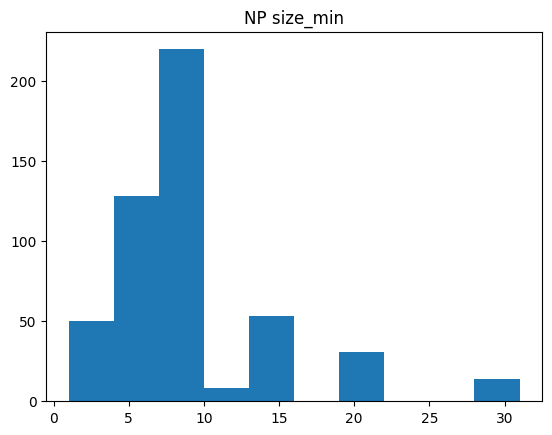

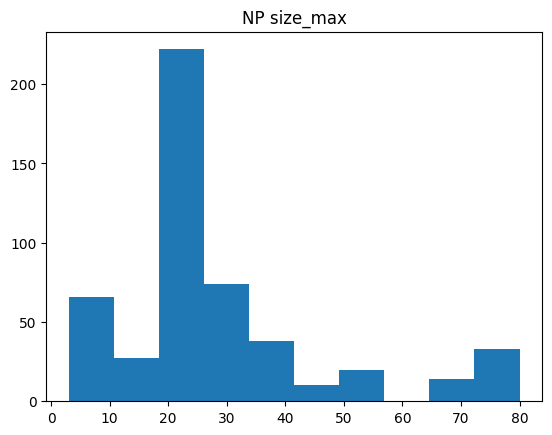

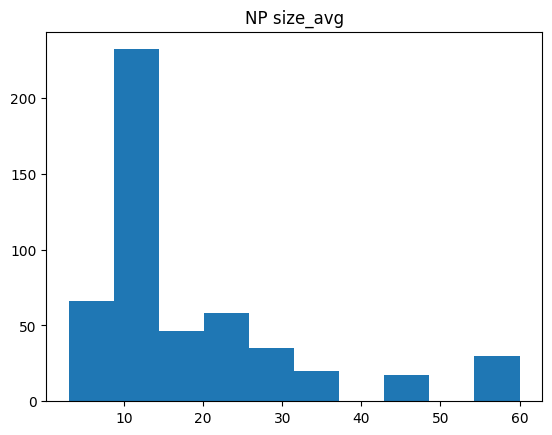

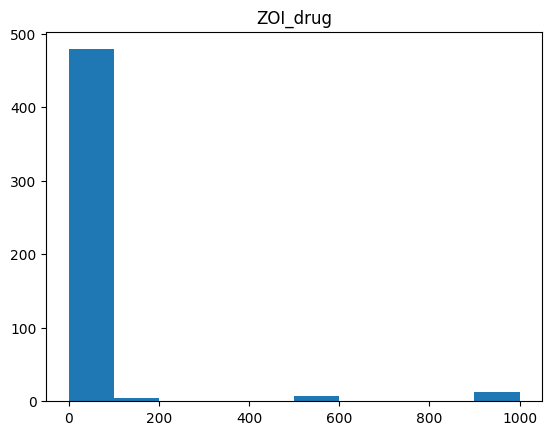

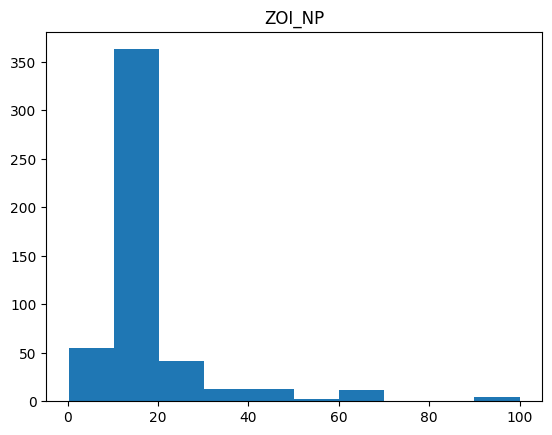

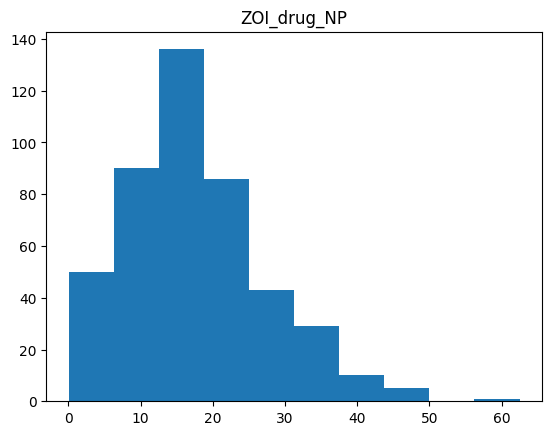

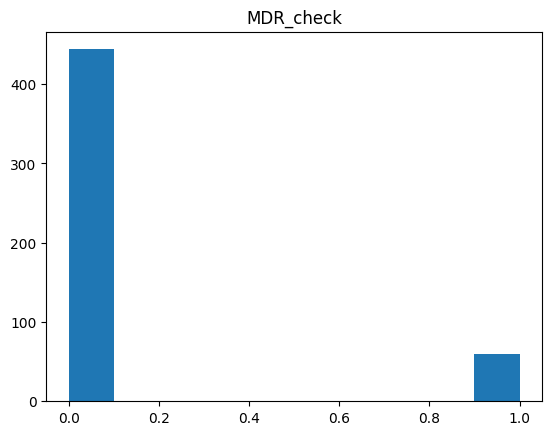

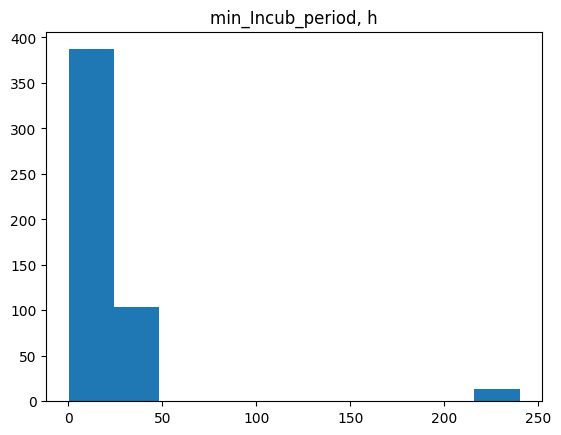

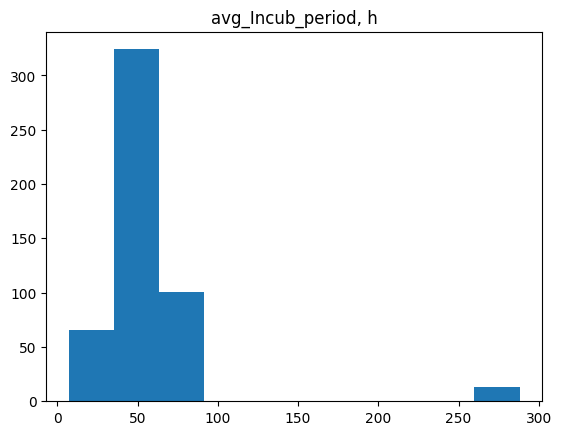

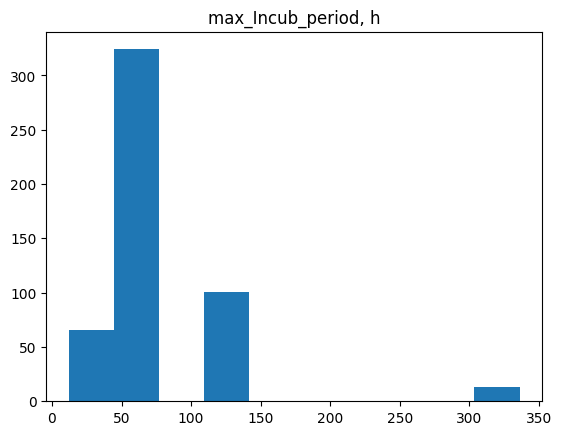

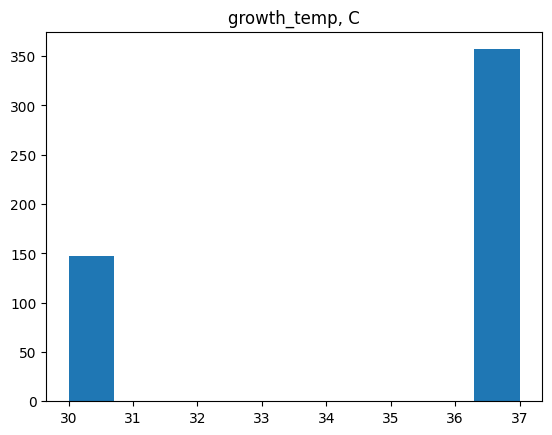

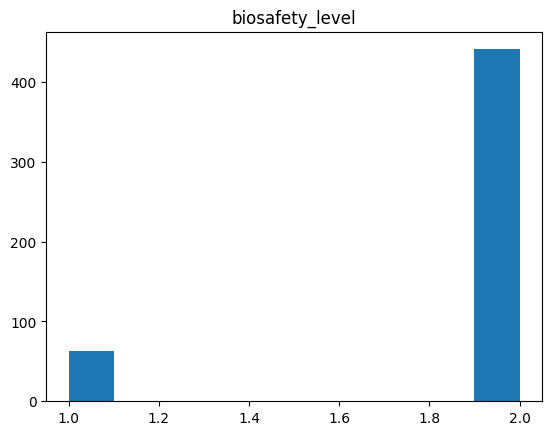

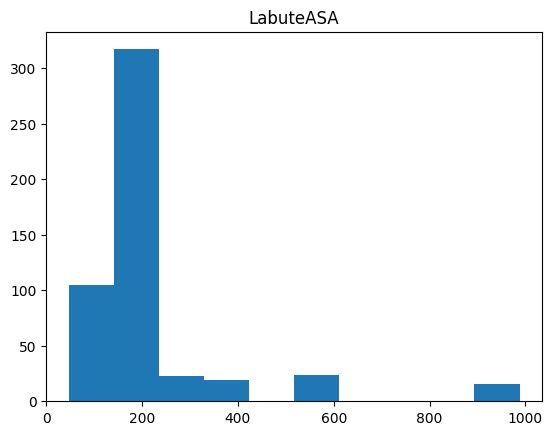

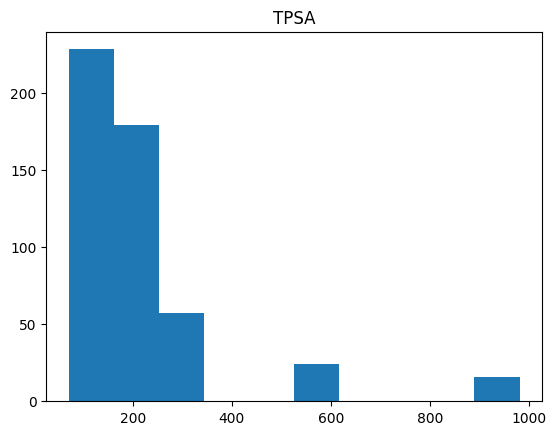

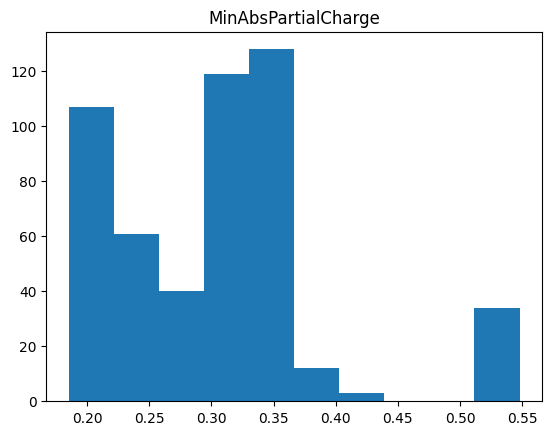

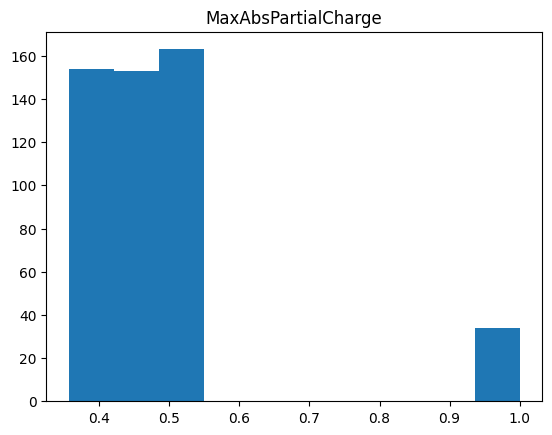

In [211]:
# стандартизация и нормализация
# идеал для нормального StandardScaler, для остальных MinMaxScaler, тут сделаем для всех
x = num_subset.values
cols = num_subset.columns
# cols
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
num_subset = pd.DataFrame(x_scaled, columns=cols)
num_subset

for i in cols:
    print(i)
    plt.figure()
    plt.hist(data[i])
    plt.title(i)

In [212]:
num_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NP size_min          504 non-null    float64
 1   NP size_max          504 non-null    float64
 2   NP size_avg          504 non-null    float64
 3   ZOI_drug             504 non-null    float64
 4   ZOI_NP               504 non-null    float64
 5   ZOI_drug_NP          450 non-null    float64
 6   MDR_check            504 non-null    float64
 7   min_Incub_period, h  504 non-null    float64
 8   avg_Incub_period, h  504 non-null    float64
 9   max_Incub_period, h  504 non-null    float64
 10  growth_temp, C       504 non-null    float64
 11  biosafety_level      504 non-null    float64
 12  LabuteASA            504 non-null    float64
 13  TPSA                 504 non-null    float64
 14  MinAbsPartialCharge  504 non-null    float64
 15  MaxAbsPartialCharge  504 non-null    flo

In [213]:
len(num_subset)

504

<Axes: >

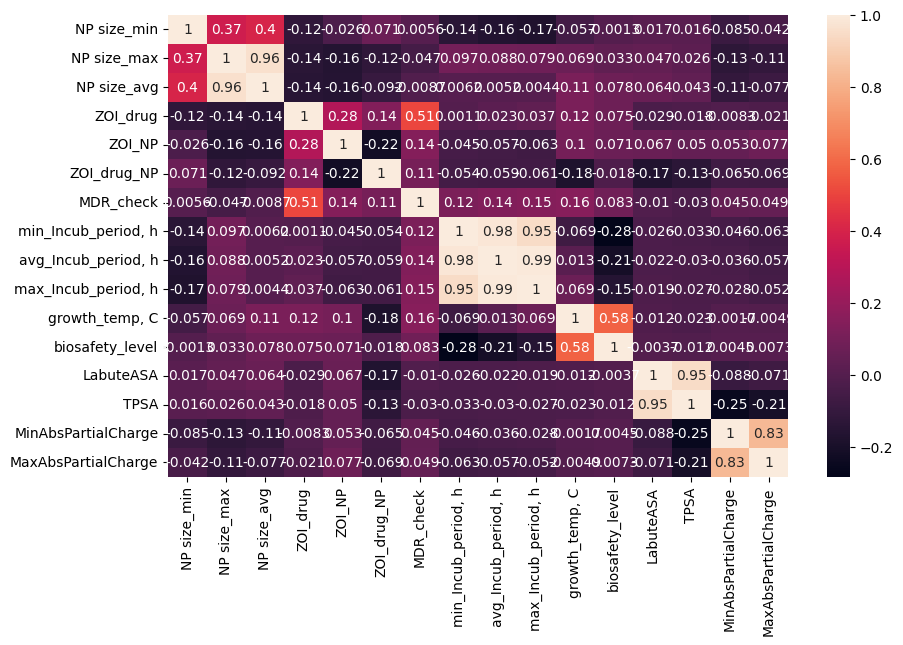

In [214]:
# Корреляционная матрица
import matplotlib.pyplot as plt
import seaborn as sns

num_subset_corr=num_subset.corr()

plt.figure(figsize = (10,6))
sns.heatmap(num_subset_corr, cmap="rocket", annot=True)

In [215]:
# Удаляем сильно коррелирующие столбцы
columns_to_drop = ['min_Incub_period, h', 'max_Incub_period, h']
num_subset = num_subset.drop(columns=columns_to_drop)

<Axes: >

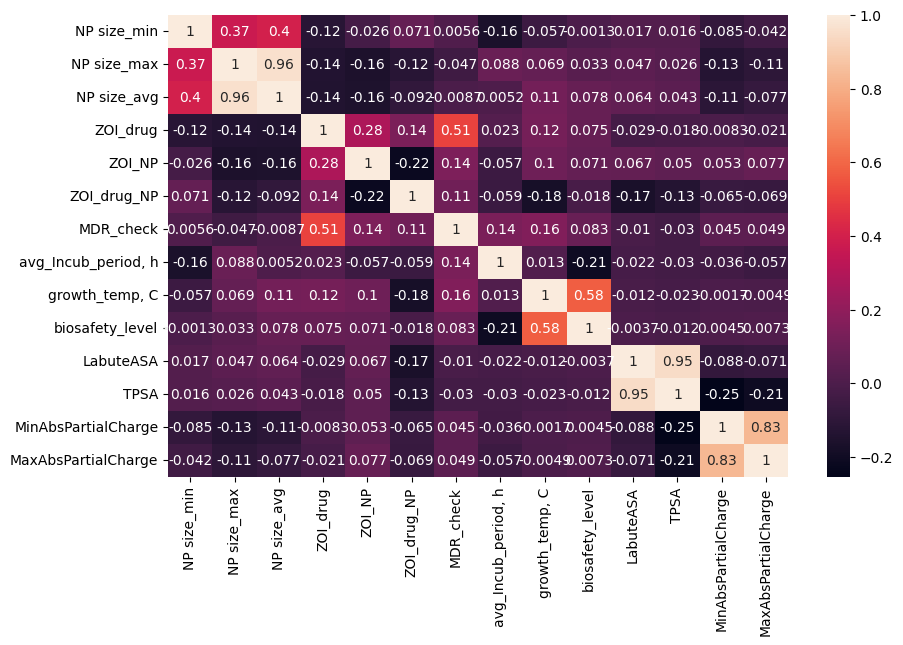

In [216]:
# Корреляционная матрица
import matplotlib.pyplot as plt
import seaborn as sns

num_subset_corr=num_subset.corr()

plt.figure(figsize = (10,6))
sns.heatmap(num_subset_corr, cmap="rocket", annot=True)

In [217]:
# Удаляем сильно коррелирующие столбцы
columns_to_drop = ['NP size_min', 'NP size_max']
num_subset = num_subset.drop(columns=columns_to_drop)

<Axes: >

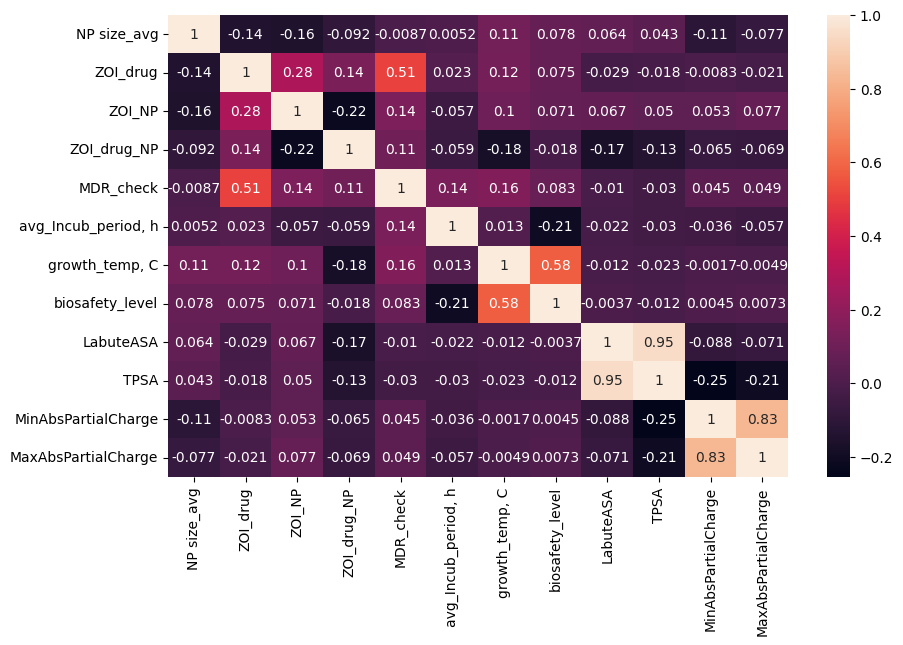

In [218]:
# Корреляционная матрица
import matplotlib.pyplot as plt
import seaborn as sns

num_subset_corr=num_subset.corr()

plt.figure(figsize = (10,6))
sns.heatmap(num_subset_corr, cmap="rocket", annot=True)

In [219]:
# Удаляем сильно коррелирующие столбцы
columns_to_drop = ['TPSA', 'MaxAbsPartialCharge']
num_subset = num_subset.drop(columns=columns_to_drop)

<Axes: >

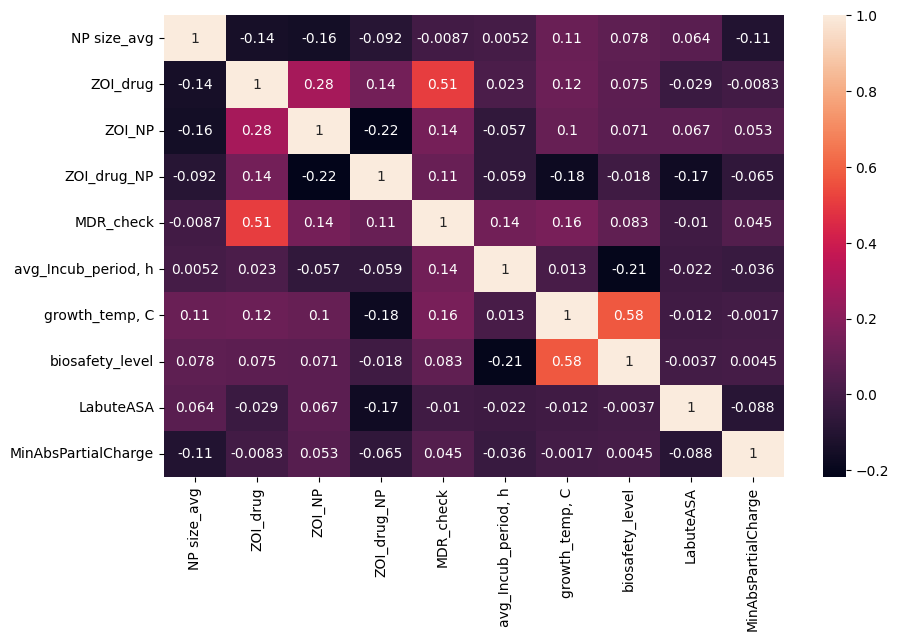

In [220]:
# Корреляционная матрица
import matplotlib.pyplot as plt
import seaborn as sns

num_subset_corr=num_subset.corr()

plt.figure(figsize = (10,6))
sns.heatmap(num_subset_corr, cmap="rocket", annot=True)

<Axes: >

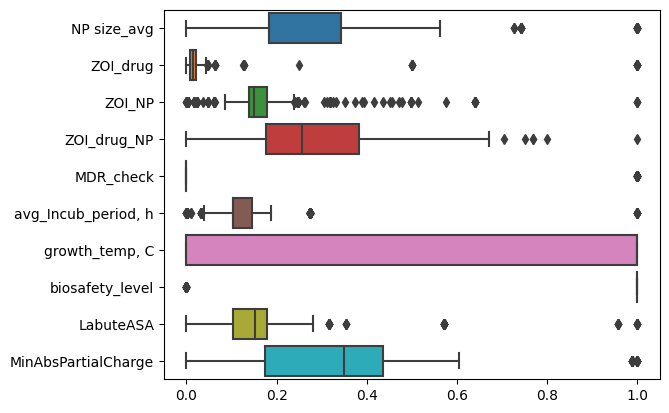

In [221]:
# проверяем выбросы
sns.boxplot(data=num_subset, orient="h")

The `size` parameter has been renamed to `height`; please update your code.


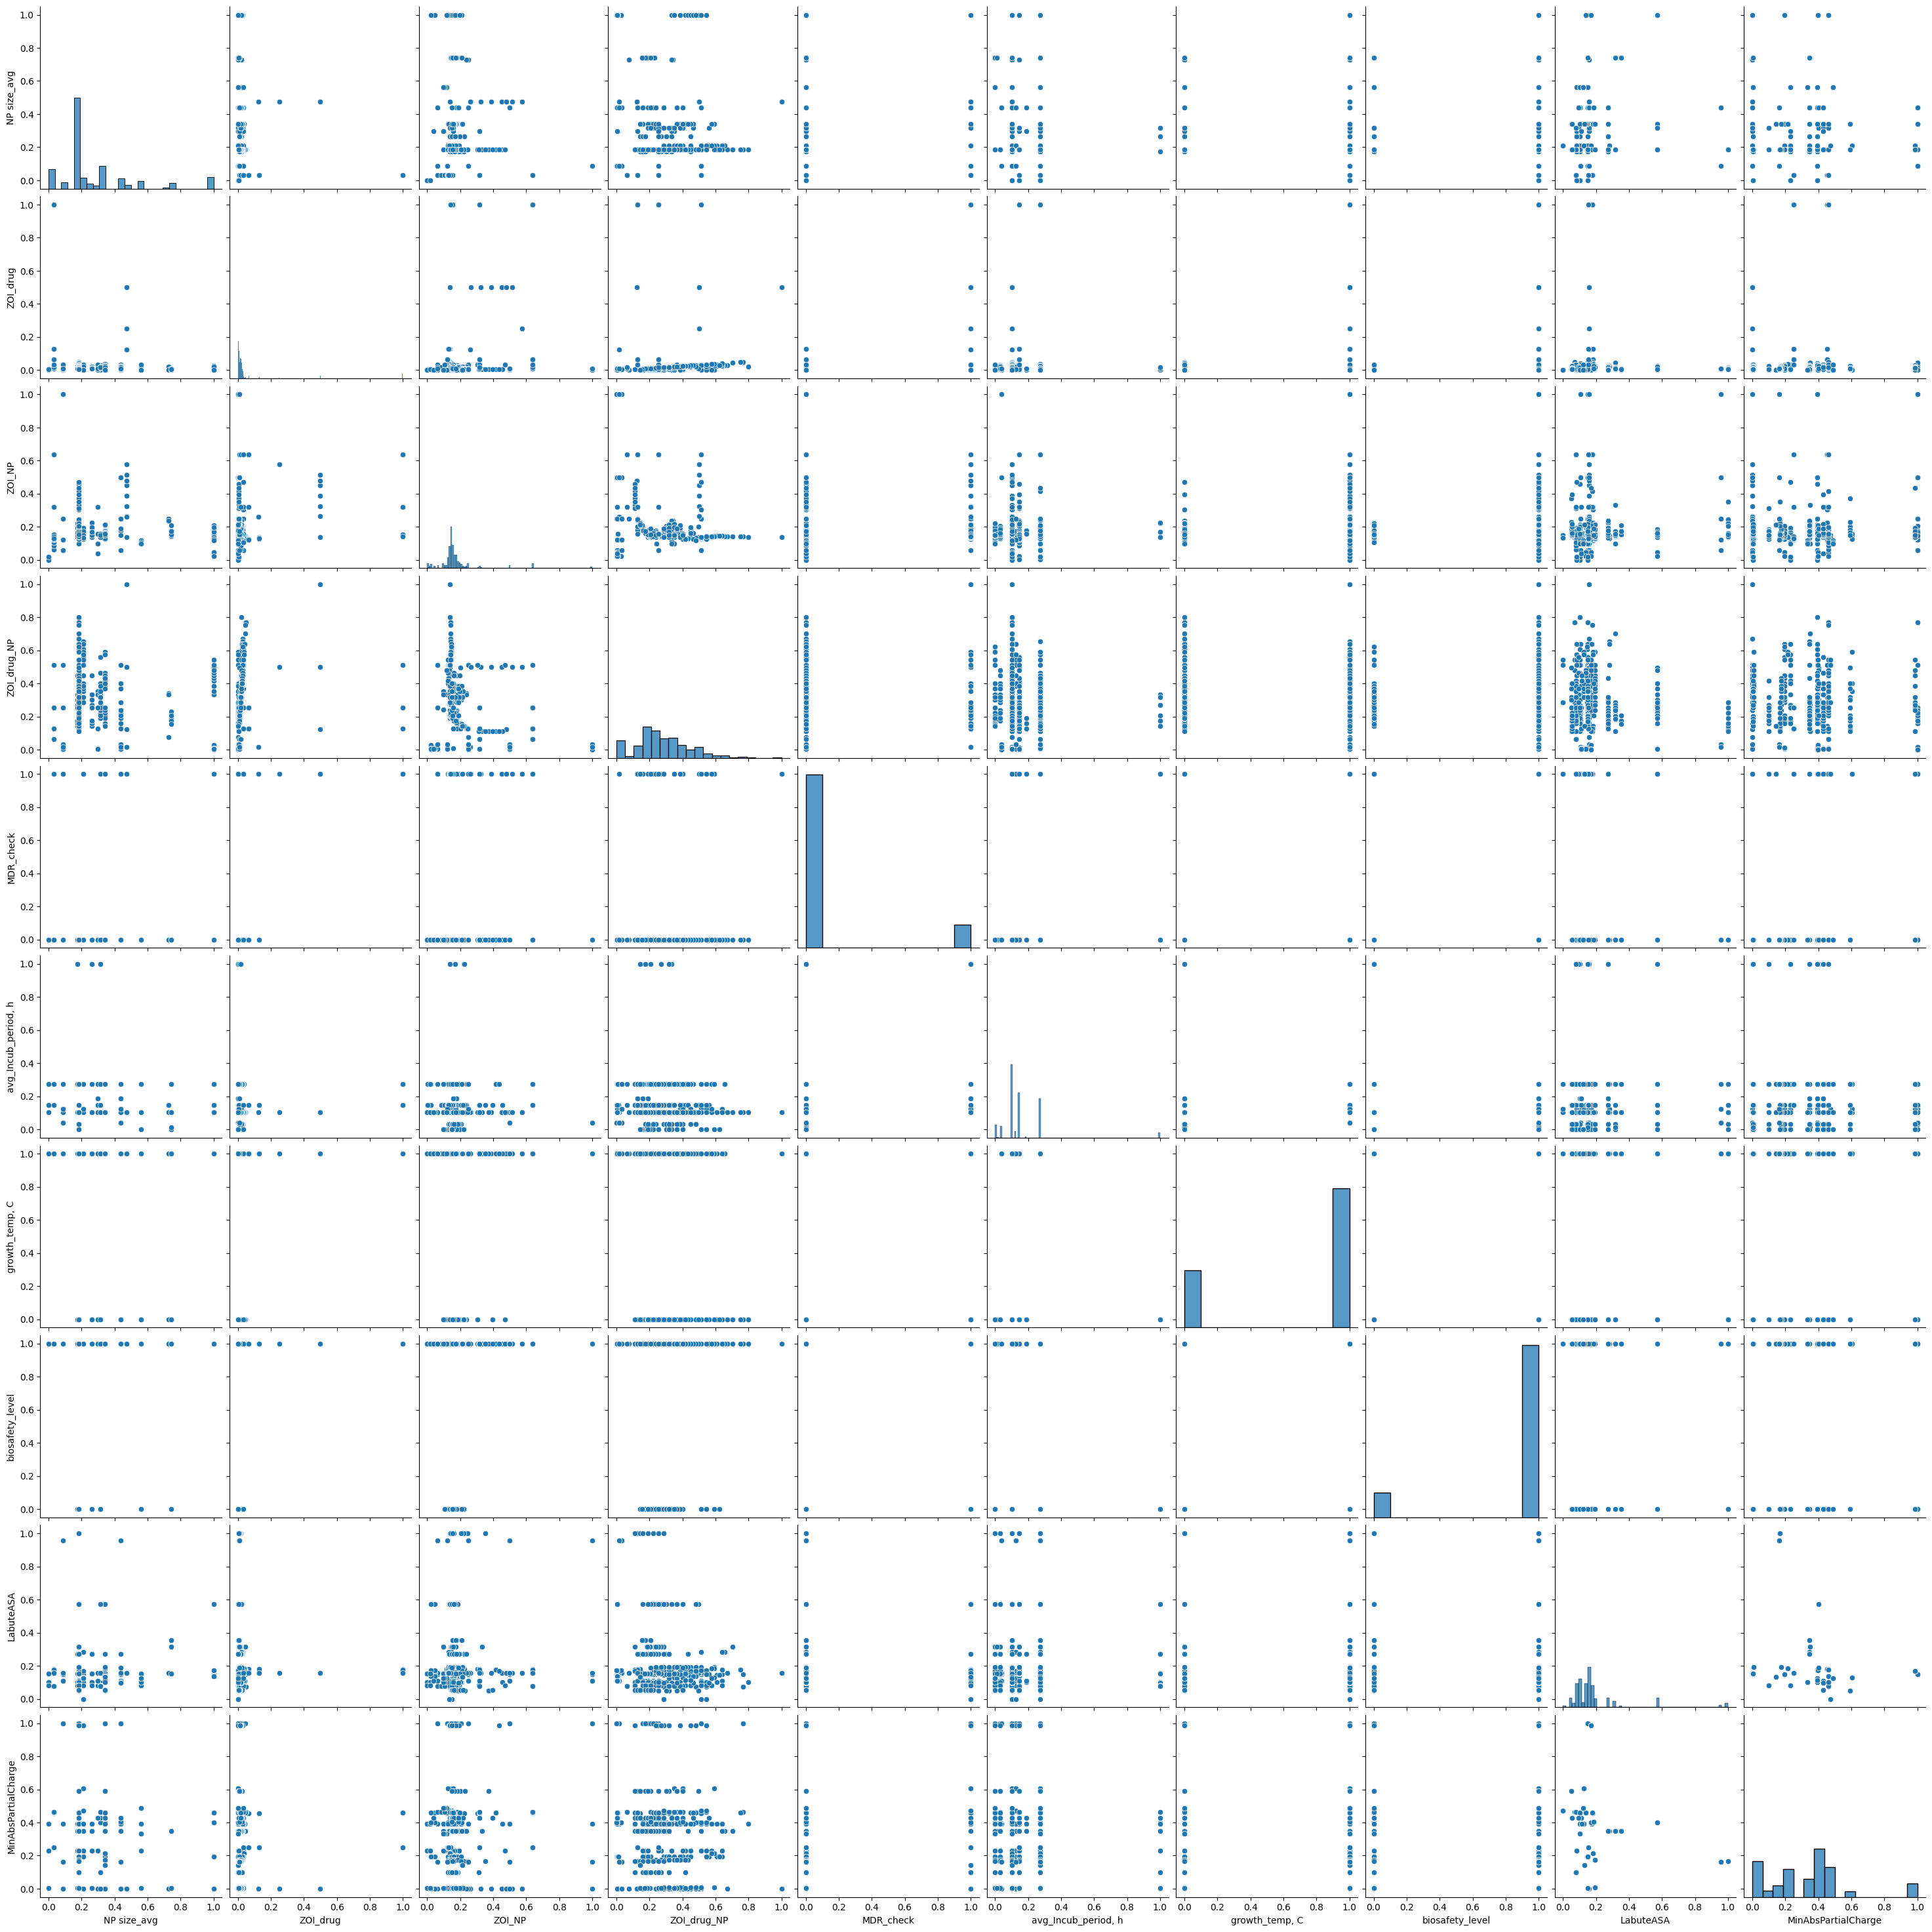

In [222]:
# Матрица графиков зависимости графиков друг от друга
sns.pairplot(num_subset, size=3)

In [223]:
!pip install seaborn
!pip install shap

import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor

In [224]:
from sklearn.model_selection import train_test_split

col_y = 'ZOI_drug_NP'
cols_X = list(set(num_subset.columns) - set([col_y]))
cols_X_sub = ['NP size_avg','ZOI_drug','ZOI_NP']

train = num_subset[~num_subset['ZOI_drug_NP'].isna()]
test = num_subset[num_subset['ZOI_drug_NP'].isna()]

print(test.shape, train.shape)

X_train, X_test, y_train, y_test = train_test_split(train[cols_X], train[col_y], test_size=0.2, random_state=42)
X_train_sub, X_test_sub, _, _ = train_test_split(train[cols_X_sub], train[col_y], test_size=0.2, random_state=42)

# Training set
print("Training set:")
print(X_train.shape, y_train.shape)
print(X_train_sub.shape)

# Test set
print("Test set:")
print(X_test.shape, y_test.shape)
print(X_test_sub.shape)

y_test


(54, 10) (450, 10)
Training set:
(360, 9) (360,)
(360, 3)
Test set:
(90, 9) (90,)
(90, 3)


449    0.223627
490    0.031535
117    0.511766
30     0.001521
457    0.207620
         ...   
408    0.200736
399    0.255643
340    0.255643
57     0.207620
180    0.223627
Name: ZOI_drug_NP, Length: 90, dtype: float64

# Обучение моделей

К презентации:
Выбор модели для решения задачи зависит от различных факторов, включая характеристики данных, целевую переменную, объем данных, требования к скорости работы, интерпретируемости и другие. Для обоснования выбора моделей линейной регрессии, градиентного бустинга и случайных лесов можно учесть следующие соображения:

**Линейная регрессия:**

Простота:

Линейная регрессия является одной из самых простых моделей, что делает ее привлекательной, особенно при небольшом объеме данных и простых зависимостях между признаками и целевой переменной.

Интерпретируемость:

Линейная регрессия обеспечивает прозрачность в том, как каждый признак влияет на целевую переменную, так как веса признаков имеют прямое значение и понятное направление.

Предположения:

Линейная регрессия основана на предположении о линейной зависимости между признаками и целевой переменной, что может быть релевантным для определенных типов данных.

**Градиентный бустинг:**

Высокая точность:

Градиентный бустинг имеет потенциал достичь высокой точности и хорошей обобщающей способности, особенно когда имеется большой объем данных.

Умение работать с различными типами признаков:

Градиентный бустинг может обрабатывать как числовые, так и категориальные признаки, а также автоматически выполнять кодирование и обработку отсутствующих значений.

Адаптивность:

Градиентный бустинг способен моделировать сложные взаимодействия между признаками и автоматически настраивать веса и деревья в процессе обучения.

**Случайные леса:**

Устойчивость к выбросам и шуму:

Случайные леса имеют свойство устойчивости к выбросам и шуму в данных, что делает их хорошим выбором, когда данные содержат неопределенность или неточности.

Возможность обрабатывать большие объемы данных:

Случайные леса могут эффективно работать с большими наборами данных, так как каждое дерево строится независимо от других деревьев.

Важность признаков:

Случайные леса предоставляют информацию о важности признаков, что позволяет определить, какие признаки имеют наибольшее влияние на целевую переменную.

In [225]:
#Linear Regression
!pip install sklearn

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Создаем экземпляр регрессора класса LinearRegression
regressor = LinearRegression()

# Обучаем модель на тренировочных данных
model = regressor.fit(X_train, y_train)

# Выполняем 6-кратную перекрестную проверку
scores = cross_val_score(model, X_train, y_train, cv=6)
print("Cross-validated scores:", scores)

# Получаем предсказания с помощью перекрестной проверки
predictions = cross_val_predict(model, X_train, y_train, cv=6)

Cross-validated scores: [0.17258129 0.15172355 0.02948637 0.21808306 0.02695485 0.01154977]


In [226]:
y_pred = model.predict(X_test)
y_pred

array([ 0.26818215,  0.24482356,  0.36655006,  0.21201548,  0.31574646,
        0.37634512,  0.33651649,  0.14647582,  0.28834844,  0.32777914,
        0.28530828,  0.18249101,  0.29626407,  0.2913491 ,  0.20676878,
        0.0877656 ,  0.29778924,  0.27737006,  0.29009689,  0.24128714,
        0.28703305,  0.29697586,  0.16531792,  0.3032742 ,  0.29498704,
        0.285336  ,  0.26777822,  0.22799918,  0.2914391 ,  0.30421181,
        0.3534319 ,  0.23098906,  0.25883283,  0.13852392,  0.31354875,
        0.3001018 ,  0.33817371,  0.24076587,  0.25434606,  0.13659476,
        0.14110262,  0.37262658,  0.28279065,  0.27013204,  0.27665534,
        0.33422144,  0.33536316,  0.26797566,  0.24904013,  0.29242692,
        0.18348177,  0.30618404,  0.28320277,  0.28349389,  0.31598945,
        0.30520889,  0.34735925,  0.30451761,  0.37121127,  0.31566892,
        0.37834802, -0.06969326,  0.25929592,  0.36267619,  0.30375835,
        0.29312936, -0.14391588,  0.41935242,  0.28461228,  0.38

In [227]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_score = r2_score(y_test, y_pred)

print(regressor.intercept_)
print(regressor.coef_)
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Accuracy: {r2_score:.2f}')

0.43574893503141293
[-0.07146245  0.25304915 -0.05650696 -0.07288105 -0.07760714 -0.10482284
 -0.43206272  0.04111581  0.05126753]
Mean absolute error: 0.12
Mean squared error: 0.02
Root mean squared error: 0.15
Accuracy: 0.25


  0%|          | 0/360 [00:00<?, ?it/s]

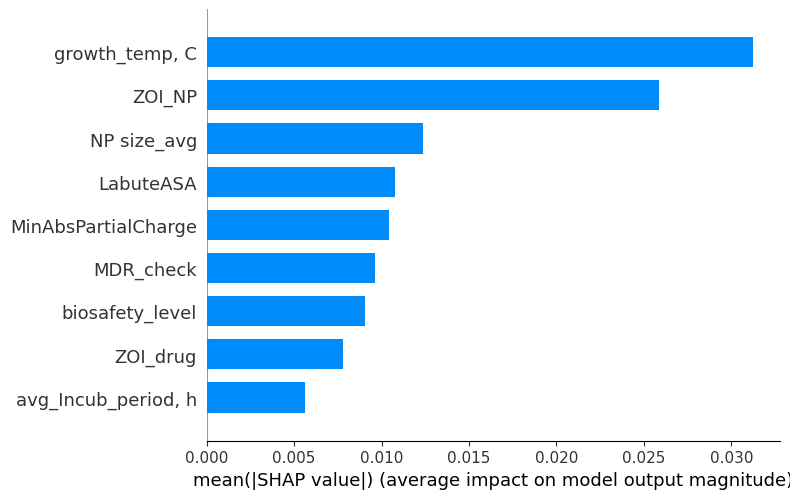

In [228]:
#анализ важности признаков (feature importance)
import shap

# Создание объекта KernelExplainer с использованием сэмплированных фоновых данных
background = shap.sample(X_train, 100)
explainer = shap.KernelExplainer(model.predict, background)

# Вычисление значений SHAP
shap_values = explainer.shap_values(X_train)

# Визуализация важности признаков
shap.summary_plot(shap_values, X_train, plot_type='bar')

In [229]:
import pickle

# Сохранение весов модели
filename = 'linear_regression_model_weights.pkl'  # Имя файла для сохранения весов
with open(filename, 'wb') as file:
    pickle.dump(regressor, file)


In [230]:
from sklearn.model_selection import train_test_split

col_y = 'ZOI_drug_NP'
cols_X = list(set(num_subset.columns) - set([col_y]))
cols_X_sub = ['NP size_avg','ZOI_drug','ZOI_NP']

train = num_subset[~num_subset['ZOI_drug_NP'].isna()]
test = num_subset[num_subset['ZOI_drug_NP'].isna()]

print(test.shape, train.shape)

X_train, X_test, y_train, y_test = train_test_split(train[cols_X], train[col_y], test_size=0.2, random_state=42)
X_train_sub, X_test_sub, _, _ = train_test_split(train[cols_X_sub], train[col_y], test_size=0.2, random_state=42)

# Training set
print("Training set:")
print(X_train.shape, y_train.shape)
print(X_train_sub.shape)

# Test set
print("Test set:")
print(X_test.shape, y_test.shape)
print(X_test_sub.shape)

y_test


(54, 10) (450, 10)
Training set:
(360, 9) (360,)
(360, 3)
Test set:
(90, 9) (90,)
(90, 3)


449    0.223627
490    0.031535
117    0.511766
30     0.001521
457    0.207620
         ...   
408    0.200736
399    0.255643
340    0.255643
57     0.207620
180    0.223627
Name: ZOI_drug_NP, Length: 90, dtype: float64

In [231]:
#Gradient Boosting Regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict

# Создаем регрессор градиентного бустинга
regressor = GradientBoostingRegressor()

# Обучение модели
model = regressor.fit(X_train, y_train)

# Выполняем 6-кратную перекрестную проверку
scores = cross_val_score(model, X_train, y_train, cv=6)
print("Cross-validated scores:", scores)

# Получаем предсказания с помощью перекрестной проверки
predictions = cross_val_predict(model, X_train, y_train, cv=6)


Cross-validated scores: [0.8076889  0.81123901 0.78420721 0.72782541 0.89955679 0.67114376]


In [232]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Вычисление метрик
y_pred = model.predict(X_test)
r2_grbregr = r2_score(y_test, y_pred)
mae_grbregr = mean_absolute_error(y_test, y_pred)
mse_grbregr = mean_squared_error(y_test, y_pred)
print("R-squared:", r2_grbregr)
print("MAE:", mae_grbregr)
print("MSE:", mse_grbregr)

R-squared: 0.7877876869899444
MAE: 0.04752127871136443
MSE: 0.005970904768843996


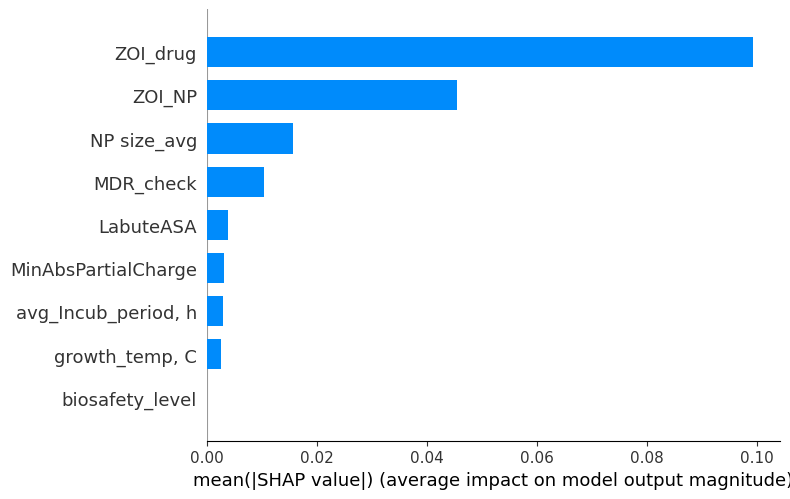

In [233]:
#анализ важности признаков (feature importance)
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type='bar')

In [234]:
import pickle

# Сохранение весов модели
filename = 'gr_boost_regression_model_weights.pkl'  # Имя файла для сохранения весов
with open(filename, 'wb') as file:
    pickle.dump(regressor, file)


In [235]:
from sklearn.model_selection import train_test_split

col_y = 'ZOI_drug_NP'
cols_X = list(set(num_subset.columns) - set([col_y]))
cols_X_sub = ['NP size_avg','ZOI_drug','ZOI_NP']

train = num_subset[~num_subset['ZOI_drug_NP'].isna()]
test = num_subset[num_subset['ZOI_drug_NP'].isna()]

print(test.shape, train.shape)

X_train, X_test, y_train, y_test = train_test_split(train[cols_X], train[col_y], test_size=0.2, random_state=42)
X_train_sub, X_test_sub, _, _ = train_test_split(train[cols_X_sub], train[col_y], test_size=0.2, random_state=42)

# Training set
print("Training set:")
print(X_train.shape, y_train.shape)
print(X_train_sub.shape)

# Test set
print("Test set:")
print(X_test.shape, y_test.shape)
print(X_test_sub.shape)

y_test


(54, 10) (450, 10)
Training set:
(360, 9) (360,)
(360, 3)
Test set:
(90, 9) (90,)
(90, 3)


449    0.223627
490    0.031535
117    0.511766
30     0.001521
457    0.207620
         ...   
408    0.200736
399    0.255643
340    0.255643
57     0.207620
180    0.223627
Name: ZOI_drug_NP, Length: 90, dtype: float64

divide by zero encountered in log10


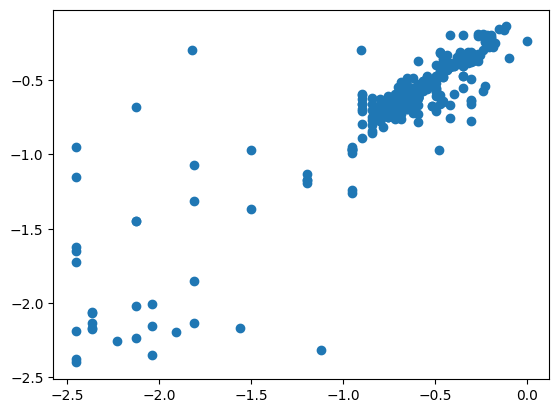

In [236]:
from sklearn.ensemble import RandomForestRegressor
#создаем регрессор случайного леса
regr = RandomForestRegressor(random_state=0, n_estimators=100, oob_score = True)
#обучаем модель случайного леса
regr.fit(X_train, y_train)
#создаем диаграмму
plt.scatter(np.log10(y_train), np.log10(regr.oob_prediction_))
plt.show()

In [237]:
#результаты предсказаний
predicted = regr.predict(X_test)
predicted

array([0.1635393 , 0.02682087, 0.2075759 , 0.01701777, 0.1933408 ,
       0.47206659, 0.19337282, 0.02023371, 0.44309268, 0.30918841,
       0.42740515, 0.19449336, 0.28221546, 0.2933408 , 0.14460381,
       0.15458087, 0.3987514 , 0.3945894 , 0.435409  , 0.24635825,
       0.46446935, 0.39651032, 0.10092845, 0.04053146, 0.2418665 ,
       0.28381623, 0.34960781, 0.50632304, 0.52457179, 0.28733792,
       0.40371378, 0.46822475, 0.45962062, 0.02446454, 0.27446774,
       0.28299984, 0.16703057, 0.23469452, 0.48119097, 0.06555947,
       0.20377301, 0.73275172, 0.23502001, 0.28861854, 0.39570994,
       0.23841044, 0.32335521, 0.26058588, 0.32303506, 0.30363374,
       0.0100016 , 0.27076197, 0.25446454, 0.00970066, 0.25858012,
       0.19641428, 0.44165199, 0.16920122, 0.42868577, 0.21893709,
       0.33608132, 0.0176981 , 0.00725948, 0.43781015, 0.29742276,
       0.2702097 , 0.03379062, 0.25290539, 0.20573715, 0.46758284,
       0.36993757, 0.23131103, 0.31831279, 0.32506163, 0.20536

In [241]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Вычисление метрик
y_pred = model.predict(X_test)
r2_rfrall = r2_score(y_test, predicted)
mae_rfrall = mean_absolute_error(y_test, predicted)
mse_rfrall = mean_squared_error(y_test, predicted)
print("R-squared:", r2_rfrall)
print("MAE:", mae_rfrall)
print("MSE:", mse_rfrall)

R-squared: 0.7937865039702551
MAE: 0.043589817927419984
MSE: 0.00580211925207965


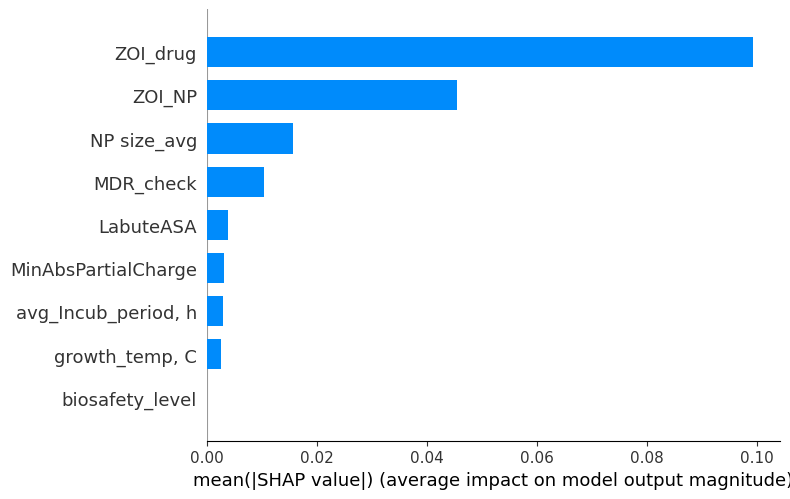

In [243]:
#анализ важности признаков
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type='bar')

In [244]:
import pickle

# Сохранение весов модели
filename = 'rand_forest_all_regression_model_weights.pkl'  # Имя файла для сохранения весов
with open(filename, 'wb') as file:
    pickle.dump(regr, file)
